<a href="https://colab.research.google.com/github/Spica08/Deep-Learning-from-Scratch/blob/main/5%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from collections import OrderedDict

In [45]:
#function

#恒等関数
def identity_function(x):
    return x

#ステップ関数
def step_function(x):
  y = x > 0
  return y.astype(int)

#シグモイド関数
def sigmoid(x):
  return 1/(1+np.exp(-x))

#ReLU関数
def ReLU(x):
  return np.maximum(0,x)

#ソフトマックス関数
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

#2乗和誤差
def mean_square_error(y, t):
  return 0.5 * np.sum((y-t)**2)

#交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す
        it.iternext()

    return grad

# 5章 誤差逆伝播法

# 5.1 計算グラフ
計算グラフとは、計算の過程をグラフにしたもの。
  


### 5.1.1 計算グラフで解く  
計算グラフを使って問題を解くには、  
(1) 計算グラフを構築する。  
(2) 計算グラフ上で計算を左から右へ進める。  
2番目のステップを**順伝播**と呼ぶ。逆に、右から左へと計算を進めることを**逆伝播**と呼ぶ。

### 5.1.2 局所的な計算
計算グラフの特徴は、「局所的な計算」を伝播することによって最終的な結果を得ることができる点にある。

### 5.1.3 なぜ計算グラフで解くのか?
計算グラフで問題を解く最大の理由は、逆伝播によって微分を効率よく計算できる点にある。  


## 5.2 連鎖律

### 5.2.1 計算グラフの逆伝播  
逆伝播では、信号Eに対して、ノードの局所的な微分($\frac{\partial y}{\partial x}$)を乗算し、それを次のノードへと伝える。

### 5.2.2 連鎖律とは  
連鎖律の原理とは、  
**ある関数が合成関数で表される場合、その合成関数の微分は、合成関数を構成するそれぞれの関数の微分の積によって表すことができる。**  
と定義される。

### 5.2.3 連鎖律と計算グラフ  
略

## 5.3 逆伝播

### 5.3.1 加算ノードの逆伝播  
z = x + y という数式を対象にして逆伝播を考える。まず、この数式の微分は、  
$\frac{\partial z}{\partial x} = 1$  
$\frac{\partial z}{\partial y} = 1$  
従って、逆伝播の際には、$\frac{\partial z}{\partial x} = 1$を乗算して下流へと伝える。

### 5.3.2 乗算ノードの逆伝播
z = xy という数式を対象にして逆伝播を考える。まず、この数式の微分は、  
$\frac{\partial z}{\partial x} = y$  
$\frac{\partial z}{\partial y} = x$  
従って、逆伝播の際には、$\frac{\partial z}{\partial x} = y$を乗算して下流へと伝える。この際、順伝播の入力信号の値が必要になるため、これを保持しておく必要がある。

## 5.4 単純なレイヤの実装

### 5.4.1 乗算レイヤの実装


In [56]:
class MulLayer:
  #順伝播時の信号を保持するための変数
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y
    return out

  #dout : 上流から伝わってきた微分
  def backward(self, dout):
    dx = self.y * dout
    dy = self.x * dout
    return dx, dy

1つ100円のりんごを2つ買い、10 % の消費税がかかる時の、支払額の合計額を求める問題における計算グラフを実装する。

In [4]:
apple = 100
apple_num = 2
tax = 1.1

#layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [48]:
#backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


### 5.4.2 加算レイヤの実装

In [57]:
class AddLayer:
  #順伝播時の信号を保持するための変数
  def __init__(self):
    pass

  def forward(self, x, y):
    out = x + y
    return out

  #dout : 上流から伝わってきた微分
  def backward(self, dout):
    dx = 1 * dout
    dy = 1 * dout
    return dx, dy

## 5.5 活性化関数レイヤの実装

### 5.5.1 ReLUレイヤ
ReLUは以下の式で表される。  
$y=\begin{cases}x&(x > 0)\\0& (x \leqq 0)\end{cases}$  
微分は、  
$\frac{\partial y}{\partial x}=\begin{cases}1&(x > 0)\\0& (x \leqq 0)\end{cases}$  
となる。

In [58]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

### 5.5.2 Sigmoidレイヤ

シグモイド関数は以下のように表される。  
$y = \frac{1}{1 + exp(-x)}$  
局所的な計算に注目して逆伝播を実装する。結果として、Sigmoid関数の微分は、  
$\frac{\partial y}{\partial x} = y(1 - y)$  
と表される。

In [50]:
class Sigmoid:
  def __init__(self, W, b):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = self.out * (1.0 - self.out) * dout
    return dx

## 5.6 Affine / Softmaxレイヤの実装

### 5.6.1 Affineレイヤ
ニューラルネットワークにおける順伝播では、入力を行列としたアフィン変換が行われる。  
詳細略

### 5.6.2 バッチ版Affineレイヤ
バイアスについて、逆伝播の際は各データにおける逆伝播の値を集約する必要があることに注意して実装する。  

In [63]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis = 0)
    return dx

### 5.6.3 Softmax-with-Lossレイヤ
ここでは、Softmaxレイヤの実装にあたって、損失関数である交差エントロピー誤差も含めた「Softmax-with-Loss」レイヤとして実装する。

In [60]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None #softmaxの出力
    self.t = None #教師データ

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size
    return dx

## 5.7 誤差逆伝播法の実装

### 5.7.1 ニューラルネットワークの学習の全体図
ニューラルネットワークの全体図は以下のようになっている。  
1(ミニバッチ) : 訓練データの中からランダムに一部のデータを選び出す。  
2(勾配の算出) : 各重みパラメータに関する損失関数の勾配を求める。  
3(パラメータの更新) : 重みパラメータを勾配方向に微少量だけ更新する。  
4(繰り返す) : ステップ1 - 3を繰り返す。  
誤差逆伝播法を用いれば、数値微分では時間がかかっていた勾配算出を高速に行うことができる。

### 5.7.2 誤差逆伝播法に対応したニューラルネットワークの実装


In [64]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
    #重みの初期化
    self.params = {}
    self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params["b1"] = np.zeros(hidden_size)
    self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params["b2"] = np.zeros(output_size)

    #レイヤの生成
    self.layers = OrderedDict()
    self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
    self.layers["Relu1"] = Relu()
    self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])

    self.lastlayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  def loss(self, x, t):
    y = self.predict(x)
    return self.lastlayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis = 1)
    if t.ndim != 1:
      t = np.argmax(t, axis = 1)
    accuracy = np.sum((y == t)) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    loss_W = lambda W:self.loss(x, t)

    grads = {}
    grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
    grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
    grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
    grads["b2"] = numerical_gradient(loss_W, self.params["b2"])

    return grads

  def gradient(self, x, t):
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.lastlayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    grads["W1"] = self.layers["Affine1"].dW
    grads["b1"] = self.layers["Affine1"].db
    grads["W2"] = self.layers["Affine2"].dW
    grads["b2"] = self.layers["Affine2"].db

    return grads

### 5.7.3 誤差逆伝播法の勾配確認
数値微分は実装が簡単でバグが起こりにくいため、処理が高速だがバグが起こりやすい誤差逆伝播法の実装が正しく行えているかを確認するためにしばしば用いられる。**勾配確認**と呼ばれている。

In [12]:
#データ準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# mnist.pyをインポート
import sys, os
sys.path.append("/content/drive/MyDrive/Colab Notebooks/ゼロから作るDeep Learning")
from mnist import load_mnist

In [23]:
np.set_printoptions(precision=10)

In [65]:
#データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

#各重みの絶対誤差の平均
for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
  print(key + ":" + str(diff))

W1:5.139487071554315e-10
b1:3.076257784789035e-09
W2:5.540096634591236e-09
b2:1.3949140139080108e-07


### 5.7.4 誤差逆伝播法を使った学習

In [66]:
#データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = True, one_hot_label = True)

# 学習過程でのlossを保存
train_loss_list = []

#ハイパーパラメータ
iters_num = 300
train_size = x_train.shape[0]
batch_size = 10
learning_rate = 0.1

#モデルの定義
network = TwoLayerNet(input_size = 784, hidden_size = 10, output_size = 10)

#ミニバッチ学習
for i in tqdm(range(iters_num)):
  #ミニバッチ取得
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  #勾配計算
  grad = network.gradient(x_batch, t_batch)

  #パラメータ更新
  for key in network.params.keys():
    network.params[key] -= learning_rate * grad[key]

  #学習過程の記録
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

100%|██████████| 300/300 [00:00<00:00, 2637.98it/s]


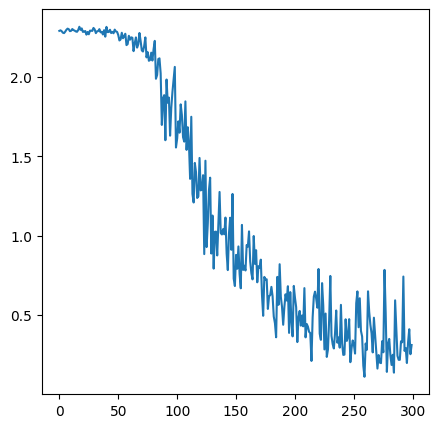

In [67]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.arange(300), train_loss_list)

In [68]:
#データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = True, one_hot_label = True)

# 学習過程でのlossを保存
train_loss_list = []
train_acc_list = []
test_acc_list = []

#ハイパーパラメータ
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

#1エポックあたりの繰り返し数
iter_per_epoch = max(train_size / batch_size, 1)

#モデルの定義
network = TwoLayerNet(input_size = 784, hidden_size = 10, output_size = 10)

#ミニバッチ学習
for i in tqdm(range(iters_num)):
  #ミニバッチ取得
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  #勾配計算
  grad = network.gradient(x_batch, t_batch)

  #パラメータ更新
  for key in network.params.keys():
    network.params[key] -= learning_rate * grad[key]

  #学習過程の記録
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("train acc, test, acc | " + str(train_acc) +", " + str(test_acc))

  0%|          | 26/10000 [00:00<02:59, 55.48it/s] 

train acc, test, acc | 0.10351666666666667, 0.0987


  7%|▋         | 658/10000 [00:03<00:49, 187.96it/s]

train acc, test, acc | 0.8835166666666666, 0.8835


 13%|█▎        | 1256/10000 [00:05<00:30, 291.16it/s]

train acc, test, acc | 0.9066833333333333, 0.9048


 19%|█▉        | 1888/10000 [00:06<00:27, 296.38it/s]

train acc, test, acc | 0.9133166666666667, 0.9121


 25%|██▍       | 2477/10000 [00:08<00:24, 311.84it/s]

train acc, test, acc | 0.9208833333333334, 0.9164


 31%|███       | 3083/10000 [00:09<00:21, 320.48it/s]

train acc, test, acc | 0.92935, 0.9261


 37%|███▋      | 3689/10000 [00:11<00:20, 308.95it/s]

train acc, test, acc | 0.93265, 0.9266


 43%|████▎     | 4304/10000 [00:12<00:17, 323.19it/s]

train acc, test, acc | 0.9346333333333333, 0.9277


 48%|████▊     | 4833/10000 [00:14<00:35, 144.51it/s]

train acc, test, acc | 0.9371166666666667, 0.9321


 55%|█████▍    | 5458/10000 [00:19<00:40, 112.76it/s]

train acc, test, acc | 0.9402666666666667, 0.935


 61%|██████    | 6055/10000 [00:20<00:13, 295.42it/s]

train acc, test, acc | 0.9414666666666667, 0.9366


 67%|██████▋   | 6655/10000 [00:22<00:11, 297.86it/s]

train acc, test, acc | 0.9399, 0.9327


 73%|███████▎  | 7303/10000 [00:23<00:08, 316.80it/s]

train acc, test, acc | 0.9409, 0.9336


 79%|███████▊  | 7874/10000 [00:25<00:07, 301.27it/s]

train acc, test, acc | 0.94245, 0.935


 85%|████████▍ | 8458/10000 [00:26<00:04, 311.78it/s]

train acc, test, acc | 0.9434833333333333, 0.9364


 91%|█████████ | 9060/10000 [00:28<00:02, 325.12it/s]

train acc, test, acc | 0.94435, 0.9353


 96%|█████████▋| 9628/10000 [00:30<00:03, 123.18it/s]

train acc, test, acc | 0.9441, 0.9357


100%|██████████| 10000/10000 [00:32<00:00, 309.93it/s]


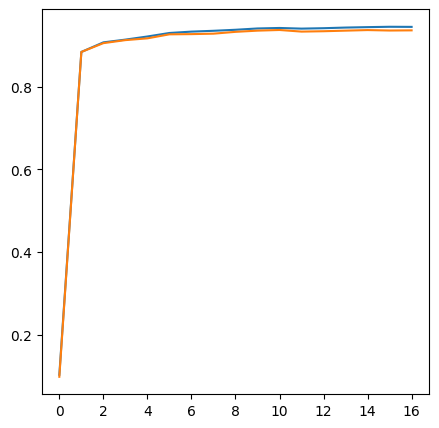

In [69]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.arange(len(train_acc_list)), train_acc_list)
ax.plot(np.arange(len(test_acc_list)), test_acc_list)
fig.show()